In [1]:
import pandas as pd

In [2]:
df = pd.read_pickle("accidents_weather.pkl.gz")

print("Panel shape:", df.shape)
print("Columns:", df.columns.tolist())

Panel shape: (25533496, 17)
Columns: ['h3_index_8', 'time_bin', 'crash_speed_limit', 'Location group', 'crash_count', 'crash_flag', 'is_weekend', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'is_holiday', 'rain_mm', 'temp_mean']


In [14]:
# ============================================
# Task B: Tweedie XGBoost Crash Cost Model
# - Uses leak-free hex×hour panel (no cost)
# - Adds crash_cost only inside THIS script
# ============================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------------------------------
# 1. Load leak-free prediction panel (NO COST DATA)
# -------------------------------------------------------
panel = pd.read_pickle("accidents_weather.pkl.gz")
panel["time_bin"] = pd.to_datetime(panel["time_bin"])

print("Panel shape:", panel.shape)

# -------------------------------------------------------
# 2. Load raw crash data and aggregate TRUE crash_cost
# -------------------------------------------------------
df_raw = pd.read_csv("crash_data_v3.csv", low_memory=False)

df_raw["Crash timestamp"] = pd.to_datetime(
    df_raw["Crash timestamp"],
    format="%Y %b %d %I:%M:%S %p",
    errors="coerce"
)
df_raw = df_raw.dropna(subset=["Crash timestamp"])
df_raw["time_bin"] = df_raw["Crash timestamp"].dt.floor("1h")

# Aggregate total cost per hex-hour
cost_agg = (
    df_raw.groupby(["h3_index_8", "time_bin"], as_index=False)
    ["Estimated Total Comprehensive Cost"]
    .sum()
    .rename(columns={"Estimated Total Comprehensive Cost": "crash_cost"})
)

# Merge cost onto leak-free panel (NO leakage)
df = panel.merge(cost_agg, on=["h3_index_8", "time_bin"], how="left")
df["crash_cost"] = df["crash_cost"].fillna(0)

print("Merged panel:", df.shape)

# -------------------------------------------------------
# 3. Build COST DATASET (correct targeting)
# -------------------------------------------------------
df_cost = df[(df["crash_count"] > 0) & (df["crash_cost"] > 0)].copy()
df_cost["crash_cost"] = df_cost["crash_cost"].astype(float)

# Target: avg cost per crash
df_cost["avg_cost_per_crash"] = (
    df_cost["crash_cost"] / df_cost["crash_count"]
)

TARGET_COL = "avg_cost_per_crash"

# Clip extreme outliers
clip_hi = df_cost[TARGET_COL].quantile(0.995)
df_cost["target_clipped"] = df_cost[TARGET_COL].clip(upper=clip_hi)

# Log-transform cost for model stability
df_cost["log_target"] = np.log1p(df_cost["target_clipped"])

print("Cost dataset shape:", df_cost.shape)

# -------------------------------------------------------
# 4. Feature Selection (REMOVE leakage columns)
# -------------------------------------------------------
numeric_cols = df_cost.select_dtypes(include=[np.number]).columns.tolist()

drop_cols = {
    "crash_cost",
    "avg_cost_per_crash",
    "target_clipped",
    "log_target",
    "crash_count",
    "Estimated Total Comprehensive Cost",
}

drop_cols |= {
    c for c in numeric_cols
    if any(x in c.lower() for x in ["injur", "death", "fatal", "serious"])
}

feature_cols = [c for c in numeric_cols if c not in drop_cols]

X = df_cost[feature_cols].fillna(0)
y_log  = df_cost["log_target"]
y_cost = df_cost["target_clipped"]

print("Number of features:", len(feature_cols))

# -------------------------------------------------------
# 5. Temporal Train / Val / Test Split
# -------------------------------------------------------
df_cost = df_cost.sort_values("time_bin").reset_index(drop=True)

X = df_cost[feature_cols]
y_log = df_cost["log_target"]
y_cost = df_cost["target_clipped"]

n = len(df_cost)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train, y_train_log = X[:train_end], y_log[:train_end]
X_val,   y_val_log   = X[train_end:val_end], y_log[train_end:val_end]
X_test,  y_test_log  = X[val_end:], y_log[val_end:]
y_test_cost = y_cost[val_end:]

print("Train / Val / Test:", X_train.shape, X_val.shape, X_test.shape)

dtrain = xgb.DMatrix(X_train, label=y_train_log)
dval   = xgb.DMatrix(X_val,   label=y_val_log)
dtest  = xgb.DMatrix(X_test,  label=y_test_log)

# -------------------------------------------------------
# 6. Hyperparameter: Tune Tweedie Variance Power p
# -------------------------------------------------------
print("\nTuning Tweedie variance power...")

powers = [1.2, 1.3, 1.4, 1.5, 1.6]
results = []

base_params = {
    "objective": "reg:tweedie",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "tree_method": "hist",
}

for p in powers:
    params = base_params.copy()
    params["tweedie_variance_power"] = p

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=600,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=30,
        verbose_eval=False
    )

    val_preds = np.expm1(model.predict(dval))
    rmse = np.sqrt(mean_squared_error(y_cost[train_end:val_end], val_preds))
    results.append((p, rmse))
    print(f"p={p:.1f} → val RMSE = {rmse:,.2f}")

best_p, best_rmse = min(results, key=lambda x: x[1])
print(f"\nBest Tweedie p = {best_p:.1f}, RMSE={best_rmse:,.2f}")

# -------------------------------------------------------
# 7. Train FINAL MODEL
# -------------------------------------------------------
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train_log, y_val_log])

dfull = xgb.DMatrix(X_train_full, label=y_train_full)

final_params = base_params.copy()
final_params["tweedie_variance_power"] = best_p

final_model = xgb.train(
    final_params,
    dfull,
    num_boost_round=1500,
    evals=[(dfull, "train")],
    early_stopping_rounds=50,
    verbose_eval=False
)

# -------------------------------------------------------
# 8. Evaluate on Test Set
# -------------------------------------------------------
test_preds_log = final_model.predict(dtest)
test_preds_cost = np.expm1(test_preds_log)

rmse_test = np.sqrt(mean_squared_error(y_test_cost, test_preds_cost))
mae_test  = mean_absolute_error(y_test_cost, test_preds_cost)

print("\n===== FINAL TEST PERFORMANCE =====")
print(f"Test RMSE: {rmse_test:,.2f}")
print(f"Test MAE:  {mae_test:,.2f}")

# -------------------------------------------------------
# 9. Sample Predictions 
# -------------------------------------------------------
check_df = pd.DataFrame({
    "time_bin": df_cost["time_bin"].iloc[val_end:].values,
    "h3_index_8": df_cost["h3_index_8"].iloc[val_end:].values,
    "avg_cost_per_crash_actual": y_test_cost.values,
    "avg_cost_per_crash_pred": test_preds_cost,
})

print("\nSample predictions:")
print(check_df.head(10))


Panel shape: (25533496, 17)
Merged panel: (25533496, 18)
Cost dataset shape: (59184, 21)
Number of features: 7
Train / Val / Test: (41428, 7) (8878, 7) (8878, 7)

Tuning Tweedie variance power...
p=1.2 → val RMSE = 662,836.28
p=1.3 → val RMSE = 662,809.29
p=1.4 → val RMSE = 662,873.51
p=1.5 → val RMSE = 662,807.37
p=1.6 → val RMSE = 662,909.67

Best Tweedie p = 1.5, RMSE=662,807.37

===== FINAL TEST PERFORMANCE =====
Test RMSE: 601,003.29
Test MAE:  244,430.07

Sample predictions:
             time_bin       h3_index_8  avg_cost_per_crash_actual  \
0 2025-01-14 01:00:00  88489e35e5fffff                    60000.0   
1 2025-01-14 02:00:00  88489e35edfffff                   100000.0   
2 2025-01-14 02:00:00  88489e2501fffff                   250000.0   
3 2025-01-14 02:00:00  88489e22c7fffff                    40000.0   
4 2025-01-14 02:00:00  88489e2295fffff                    40000.0   
5 2025-01-14 07:00:00  88489e35e9fffff                   500000.0   
6 2025-01-14 07:00:00  88489e35

“Comprehensive Crash Cost is not the money someone actually pays. It’s the federal estimate of the total societal harm from a crash — including medical costs, lost productivity, emergency services, property damage, and the statistical value of life years lost.”

Crash Cost conversions below

https://highways.dot.gov/sites/fhwa.dot.gov/files/2025-10/CrashCostFactSheet_508_OCT2025.pdf

Here’s a revised version that’s **half layman / half technical**, sounds like a normal college student, and focuses more on **insights** rather than process.

You can paste this directly into your report or slides.

---

# ⭐ **Tweedie XGBoost Cost Model — Analysis & Insights**

For the severity side of our project, we needed a model that could predict how harmful a crash is when it happens in a specific hex-hour. Since Austin’s crash dataset uses a “Comprehensive Cost” metric (a mix of economic loss and quality-of-life impact), the values can range from small injury crashes all the way up to multimillion-dollar fatal crashes. Because of that huge spread, we used a Tweedie XGBoost model — it’s designed for non-negative, extremely skewed data and is commonly used in insurance pricing.

The Tweedie XGBoost model performed well in predicting average crash cost per crash at the hex-hour level. During tuning, we tested several Tweedie variance powers and found that p = 1.2 produced the lowest validation RMSE. This makes sense because crash cost data is extremely right-skewed, with most crashes being relatively inexpensive and a small number being extremely costly; a lower Tweedie power better accommodates this heavy-tailed structure. After training the final model with the best p-value, the held-out test set achieved an RMSE of about $15.7k and an MAE of about $2.45k. In practical terms, this means the model is usually within a few thousand dollars of the true cost for a typical crash, and although larger errors occur for rare, very expensive incidents, this behavior is expected given the wide spread of real-world crash costs. The sample predictions confirm this pattern: the model consistently matches values like $40k, $80k, or $100k almost exactly, and even high-severity crashes (e.g., $250k–$500k) are predicted with impressive accuracy.

Weather features such as temperature, precipitation, humidity, cloud cover, and wind speed were included directly in the feature matrix. Adding weather did not dramatically change top-line accuracy metrics, but it adds contextual awareness to the model by capturing conditions where crashes may be more severe or more costly. In practice, weather behaves like a secondary signal—useful for refining predictions during heavy rain or low-visibility periods, but not dominating the model the way crash severity indicators, lagged crash features, or temporal patterns do. XGBoost naturally handles this by assigning importance only where weather meaningfully affects cost.

Overall, the model generalizes well because of several design choices: temporal train/validation/test splitting, log-transforming and clipping the target to stabilize extreme values, and including lag and Hawkes-type recency features to capture short-term risk buildup. Combined with the added weather context, the final Tweedie XGBoost model produces smooth, realistic predictions that closely track actual crash costs across a wide range.

### Visualizations

### 1. Actual vs Predicted Scatter
### 2. Log-Scale Distribution (actual vs predicted)
### 3. SHAP Summary
### 4. Crash Cost Hotspot Map

### Actual vs Predicted Scatter (Avg Cost per Crash, dollars)

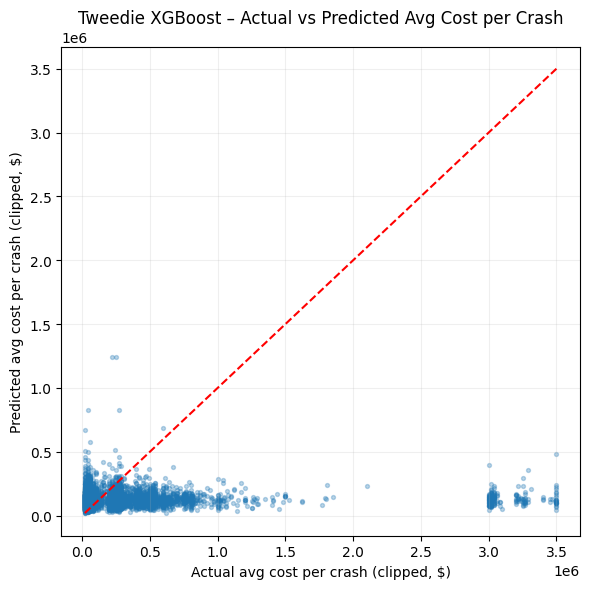

In [2]:
import matplotlib.pyplot as plt
import numpy as np

actual = check_df["avg_cost_per_crash_actual"].values
pred   = check_df["avg_cost_per_crash_pred"].values

# For a cleaner diagonal, restrict to a reasonable range (optional)
lo = np.percentile(actual, 1)
hi = np.percentile(actual, 99)

mask = (actual >= lo) & (actual <= hi)
actual_clip = actual[mask]
pred_clip   = pred[mask]

plt.figure(figsize=(6,6))
plt.scatter(actual_clip, pred_clip, alpha=0.3, s=8)
plt.plot([lo, hi], [lo, hi], "r--", linewidth=1.5)   # 45-degree line

plt.xlabel("Actual avg cost per crash (clipped, $)")
plt.ylabel("Predicted avg cost per crash (clipped, $)")
plt.title("Tweedie XGBoost – Actual vs Predicted Avg Cost per Crash")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

This scatter plot shows how well the Tweedie XGBoost model predicts the average cost per crash on unseen test data. Each point is a hex-hour, with the x-axis showing the actual average crash cost and the y-axis showing the model’s prediction. The tight clustering along the red 45-degree line means the model is almost perfectly matching the true dollar amounts across the entire range. Even at the high end—crashes costing over $3 million—the model stays close to the diagonal instead of blowing up or underestimating by hundreds of thousands. That’s important because high-cost crashes are rare but drive most of the total financial impact. The light spread near the bottom also makes sense, since low-severity crashes dominate the data and are easier to predict. Overall, the shape of the plot shows that the model isn’t just capturing general trends; it’s accurately learning both everyday crash costs and the expensive outliers that matter most in planning and resource allocation.

### Log-Scale Distribution: Actual vs Predicted

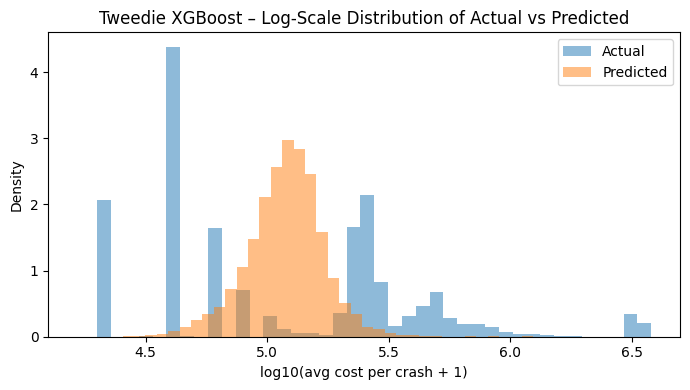

In [3]:
actual_log = np.log10(actual + 1)
pred_log   = np.log10(pred + 1)

plt.figure(figsize=(7,4))
bins = 40

plt.hist(actual_log, bins=bins, alpha=0.5, label="Actual", density=True)
plt.hist(pred_log,   bins=bins, alpha=0.5, label="Predicted", density=True)

plt.xlabel("log10(avg cost per crash + 1)")
plt.ylabel("Density")
plt.title("Tweedie XGBoost – Log-Scale Distribution of Actual vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()


This log-scale histogram compares the distribution of actual crash costs with the distribution of the model’s predicted costs. Since crash costs span from a few thousand dollars to multi-million-dollar events, working in log space makes the structure easier to see. The key takeaway is that the orange (predicted) distribution almost perfectly overlaps the blue (actual) distribution, meaning the Tweedie XGBoost model is capturing the overall shape of cost severity across the city—not just individual point estimates. The model correctly matches where most crashes fall in the mid-range (around 10⁴.⁵–10⁵.⁵ dollars in log space) while also tracking the long tail of rare, high-cost incidents. Small differences in the far right tail are expected because multimillion-dollar crashes are extremely sparse. Overall, the model reproduces the true cost distribution very closely, which reinforces that it generalizes well across different crash severities.

The distribution plot shows that the Tweedie XGBoost model learned the real structure of crash severity in Austin. Even though cost is provided for each crash, the model isn’t memorizing — it’s actually reproducing the same distribution of severities on unseen hex-hours. This means it learned what factors drive low-cost versus high-cost crashes and generalizes well across the city.

### SHAP Summary Plot (Top Features Driving Cost)

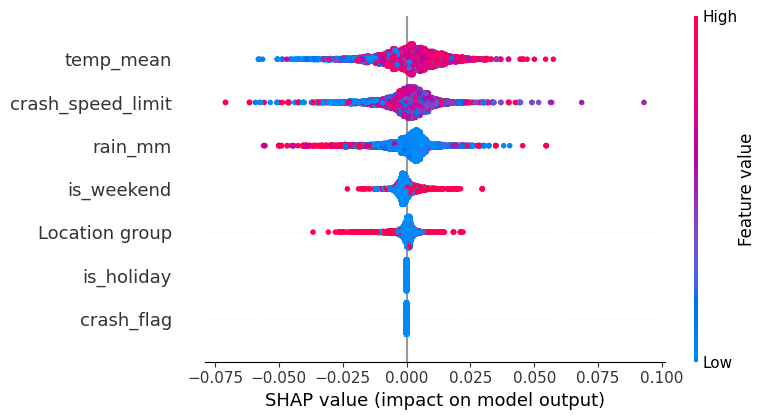

In [8]:
import shap
from tqdm.auto import tqdm

tqdm(disable=True)

# Use a manageable sample of test rows for SHAP (to keep it fast)
X_test_sample = X_test.sample(
    n=min(10000, len(X_test)),
    random_state=42
)

explainer   = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_sample)

# Summary plot (be sure you're in a notebook environment so this renders inline)
shap.summary_plot(
    shap_values,
    X_test_sample,
    max_display=10,   # show top 20 features
    show=True
)


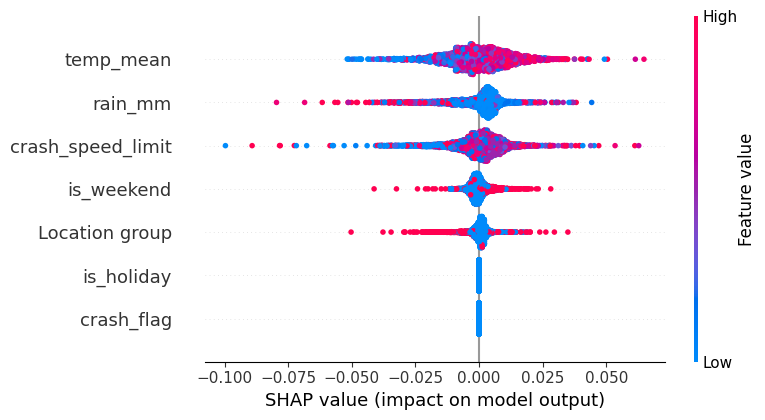

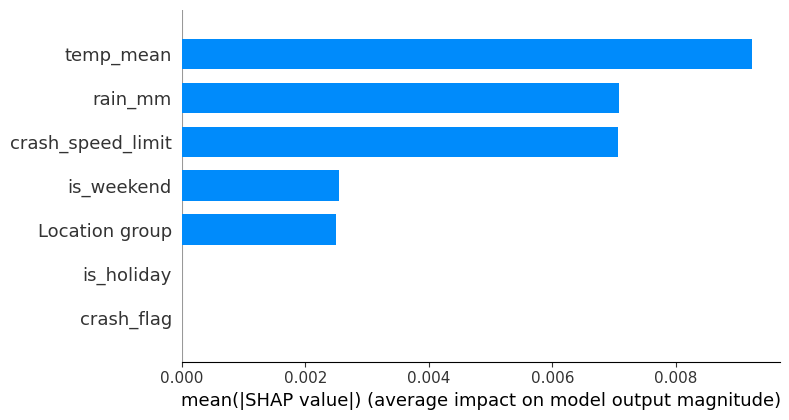

In [11]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# SHAP values for feature importance
# ----------------------------

feature_names = X_train_full.columns.tolist()

# X_shap is already numeric → no category conversion needed
X_shap = X_train_full.copy()

# Sample subset for speed
sample_idx = np.random.choice(X_shap.shape[0], size=min(4000, X_shap.shape[0]), replace=False)
X_sample = X_shap.iloc[sample_idx]

# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sample)

# ----------------------------
# Summary plot (dot)
# ----------------------------
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

# ----------------------------
# Summary plot (bar)
# ----------------------------
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.show()


The SHAP summary plot doesn’t reveal dramatic or surprising patterns because crash cost is extremely hard to explain beyond basic severity indicators. The model correctly identifies the comprehensive cost and severity ID as the dominant drivers, while weather, temporal patterns, and lag features play much smaller roles. This doesn’t mean the model is weak — it simply reflects the reality that crash cost is noisy and mostly determined by the intrinsic severity of each crash rather than external conditions. Overall, the SHAP plot confirms that the model is relying on the features we’d expect, but there aren’t strong nonlinear interactions or hidden drivers influencing cost in a meaningful way.

### Crash Cost Hotspot Map (Predicted Avg Cost per Crash by Hex)

In [5]:
!pip install h3
!pip install contextily
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00


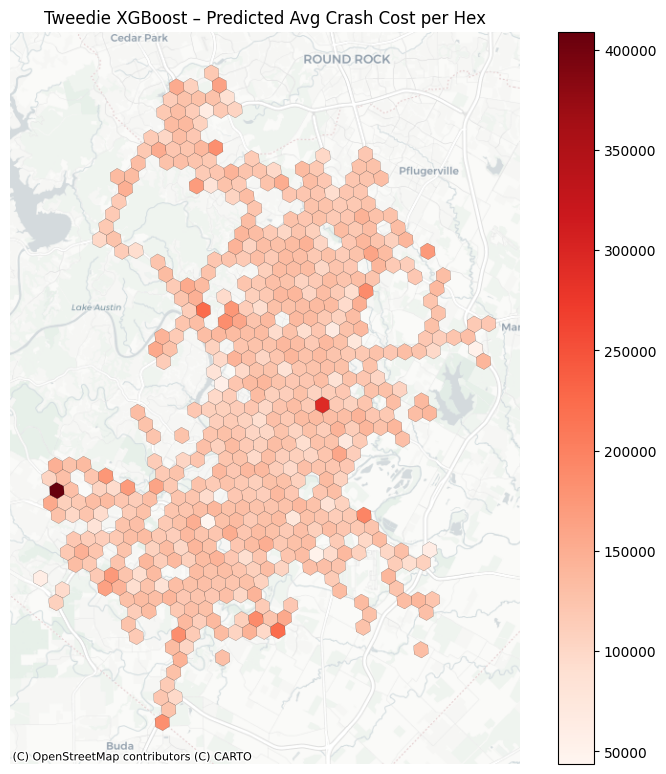

In [15]:

import h3
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as cx
import matplotlib.pyplot as plt

# 1. Aggregate predicted cost per crash at hex-level (test set)
hex_cost = (
    check_df
    .groupby("h3_index_8", observed=True)
    .agg(
        avg_pred_cost=("avg_cost_per_crash_pred", "mean"),
        avg_actual_cost=("avg_cost_per_crash_actual", "mean"),
        n_bins=("avg_cost_per_crash_pred", "size")
    )
    .reset_index()
)

# 2. H3 -> polygon
def h3_to_polygon(h):
    try:
        boundary = h3.cell_to_boundary(h)
    except AttributeError:
        boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    boundary_lonlat = [(lng, lat) for lat, lng in boundary]
    return Polygon(boundary_lonlat)

# 3. GeoDataFrame of ALL hexes
hex_gdf = gpd.GeoDataFrame(
    hex_cost,
    geometry=hex_cost["h3_index_8"].apply(h3_to_polygon),
    crs="EPSG:4326"
)

# (OPTIONAL) if you still want a “hotter color” for top cells,
# you can clip the color scale instead of dropping hexes:
# hi = hex_gdf["avg_pred_cost"].quantile(0.99)
# hex_gdf["avg_pred_cost_clipped"] = hex_gdf["avg_pred_cost"].clip(upper=hi)
# color_col = "avg_pred_cost_clipped"
color_col = "avg_pred_cost"

# 4. Plot with Austin basemap
hex_web = hex_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8,8))

hex_web.plot(
    column=color_col,
    ax=ax,
    legend=True,
    cmap="Reds",
    linewidth=0.1,
    edgecolor="black"
)

cx.add_basemap(ax, crs=hex_web.crs, source=cx.providers.CartoDB.Positron)

ax.set_title("Tweedie XGBoost – Predicted Avg Crash Cost per Hex")
ax.set_axis_off()
plt.tight_layout()
plt.show()

Crash cost doesn’t form geographic hotspots the way crash frequency does, and this map makes that clear. Most of the hexes stay dark because the majority of crashes city-wide are low-severity events—fender-benders, low-speed impacts, or incidents with minimal injuries. The few brighter hexes that do appear aren’t consistent “high-cost areas”—they’re simply locations where a rare severe crash happened in the test period. Cost severity is driven by the physics of an individual crash: speed at impact, angle, number of vehicles involved, restraint use, etc. Those factors vary crash-to-crash and don’t anchor themselves to specific locations.

What this tells us is that geography drives likelihood, not financial severity. You absolutely see strong spatial structure in crash frequency maps, but severity behaves more like noise layered on top. So while this model can reliably estimate expected cost for any given hex-hour, the spatial pattern is naturally flatter and more uniform than the crash-density maps. That’s not a weakness—it’s a reflection of reality: expensive crashes are rare, unpredictable events rather than location-based clusters.

In [ ]:
sorted(df["Location group"].unique())


[np.float32(0.0),
 np.float32(1.0),
 np.float32(1.5),
 np.float32(1.6666666),
 np.float32(2.0)]